# Amplitudes analysis

In [139]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt #this is the traditional method
from statistics import stdev
from scipy.optimize import curve_fit # import method used here

Importing data from files:
- Frequencies and tension amplitudes
- (Constant frequency) Tension-time measurements to estimate noise through generator amplitude

In [140]:
file_folder = '../data/III session/Frequency response/'
file_name = 'amplitudes_fino35kHz.csv'
data_file = file_folder + file_name
frequencies, amplitudeGen, amplitudeR, amplitudeL, amplitudeC  = np.loadtxt(data_file, delimiter = ',', skiprows = 1, usecols = (0, 1, 2, 3, 4), unpack = True)

folder = '../data/III session/Constant frequency/'
file_name = 'ampFCost19.5kHz.csv'
data_file = folder + file_name
freqFcost, ampGenFcost = np.loadtxt(data_file, delimiter=',', skiprows=1, usecols=(0,1), unpack=True)

The data scatter plots are the following:

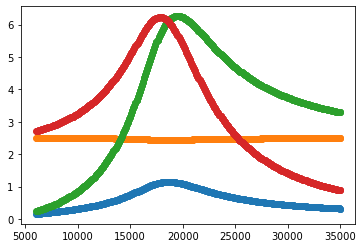

In [141]:
plt.scatter(frequencies,amplitudeR)
plt.scatter(frequencies,amplitudeGen)
plt.scatter(frequencies,amplitudeL)
plt.scatter(frequencies,amplitudeC)

plt.savefig('../figs/scatterplot amplitudes.pdf')

## Peak finding(resonance condition)

In [142]:
semidispersione = (max(ampGenFcost) - min(ampGenFcost)  ) / 2

semidispersione

0.0005150000000000432

In [143]:
from scipy.signal import find_peaks
x = amplitudeR
# peaks, _ = find_peaks(x, height=0)
# plt.plot(x)
# plt.plot(peaks, x[peaks], "x")
# plt.plot(np.zeros_like(x), "--", color="gray")
# plt.show()


maximum_value = max(amplitudeR)

i = 0
while i < len(frequencies):
    if amplitudeR[i] == maximum_value:
        print("Resonance frequency for R:" , frequencies[i])
        break
    i += 1

maximum_value = max(amplitudeL)

i = 0
while i < len(frequencies):
    if amplitudeL[i] == maximum_value:
        print("Resonance frequency for L:" , frequencies[i])
        break
    i += 1

maximum_value = max(amplitudeC)
i = 0
while i < len(frequencies):
    if amplitudeC[i] == maximum_value:
        print("Resonance frequency for C:" , frequencies[i])
        break
    i += 1


Resonance frequency for R: 18599.8
Resonance frequency for L: 19499.7
Resonance frequency for C: 17799.8


We now compute $\sigma$ from data (half period since the use of a square wave) and we use it as our noise estimation.

In [144]:
sigma_y = stdev(ampGenFcost)
sigma_x = stdev(freqFcost)

sigma_y = np.sqrt(sigma_y**2 + sigma_x**2)
freqError = []
for x in range(len(frequencies)):
    freqError.append(sigma_x)
ampError = []
for x in range(len(frequencies)):
    ampError.append(sigma_y)

sigma_y

0.03948850095551997

---
## Fitting data
We are now going to use curve_fit() method from scipy.
We now define the function we are going to fit the data with: $$ V_R = \frac{R_rV_0}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$
$$ V_L = \frac{\omega L V_0}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$
$$ V_C = \frac{\frac{V_0}{\omega C}}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$

 $\omega = 2 \pi f$ with $f$ being the sinusoidal generator frequency. We've chosen to estimate the uncertainty associated to the amplitude measures with the sample standard deviation $\sigma$ since how the DAQ program outputs the amplitude values is not known.

In [145]:
def Gen_amp_model(f, V_0):
    return V_0
def R_amp_model(f, R_r , R, L, C, V_0):
    num = R_r * V_0
    den = np.sqrt( R**2 + (2*np.pi*f * L - 1/(2*np.pi*f * C))**2)
    return num / den
def L_amp_model(f, R, L, C, V_0):
    num = 2*np.pi*f * L * V_0
    den = np.sqrt( R**2 + (2*np.pi*f * L - 1/(2*np.pi*f * C))**2)
    return num / den
def C_amp_model(f, R, L, C, V_0):
    num = V_0 / (2*np.pi*f * C)
    den = np.sqrt( R**2 + (2*np.pi*f * L - 1/(2*np.pi*f * C))**2)
    return num / den

We now have to make our initial guess of the fitting parameters. We can make exact initial guesses or set bounds for params values

In [146]:
R_r = 996.7
R = 1.17252e+03
L = 4.741e-02
C = 1.46e-09
V_0 = 2.5

initial_guess_gen = np.array([V_0])
initial_guess_R = np.array([R_r , R, L, C, V_0])
initial_guess_L = np.array([R, L, C, V_0])
initial_guess_C = np.array([R, L, C, V_0])

boundsGen = [[0.0],[3.0]]
boundsR = [[900,990,3.0e-02,1.0e-09,0.0],[1200,2500,5e-02,1.8e-09,3.0]]
boundsL = [[900,3.0e-02,1.0e-09,0.0],[2500,5e-02,1.8e-09,3.0]]
boundsC = [[900,3.0e-02,1.0e-09,0.0],[2500,5e-02,1.8e-09,3.0]]

In [147]:
# the method returns two arrays: one with the resulting fit parameters and then the covariance matrix
fit_gen,covariance_gen = curve_fit(Gen_amp_model, frequencies, amplitudeGen,bounds=boundsGen,sigma=ampError)
fit_R, covariance_R = curve_fit(R_amp_model, frequencies, amplitudeR,bounds=boundsR,sigma=ampError)
fit_L, covariance_L = curve_fit(L_amp_model, frequencies, amplitudeL,bounds=boundsL,sigma=ampError)
fit_C, covariance_C = curve_fit(C_amp_model, frequencies, amplitudeC,bounds=boundsC,sigma=ampError)

#the elements on the the diagonal represent the errors on the fit parameters
error_gen = np.sqrt(np.diag(covariance_gen))
error_R = np.sqrt(np.diag(covariance_R))
error_L = np.sqrt(np.diag(covariance_L))
error_C = np.sqrt(np.diag(covariance_C))

### Fit results
Printing out fit results

In [148]:
print()
print('V_0    = ','{:.3f}'.format(fit_gen[0]), '±', '{:.10f}'.format(error_gen[0]), ' V')

print()
print('R_r    = ','{:.3f}'.format(fit_R[0]), '±', '{:.10f}'.format(error_R[0]), ' $\Omega$')
print('R    = ','{:.3f}'.format(fit_R[1]), '±', '{:.10f}'.format(error_R[1]), ' $\Omega$')
print('L    = ','{:.5f}'.format(fit_R[2]), '±', '{:.10f}'.format(error_R[2]), ' Henry')
print('C    = ','{:.12f}'.format(fit_R[3]), '±', '{:.12f}'.format(error_R[3]), ' F')
print('V_0    = ','{:.3f}'.format(fit_R[4]), '±', '{:.10f}'.format(error_R[4]), ' V')

print()
print('R    = ','{:.3f}'.format(fit_L[0]), '±', '{:.10f}'.format(error_L[0]), ' $\Omega$')
print('L    = ','{:.5f}'.format(fit_L[1]), '±', '{:.10f}'.format(error_L[1]), ' Henry')
print('C    = ','{:.12f}'.format(fit_L[2]), '±', '{:.12f}'.format(error_L[2]), ' F')
print('V_0    = ','{:.3f}'.format(fit_L[3]), '±', '{:.10f}'.format(error_L[3]), ' V')

print()
print('R    = ','{:.3f}'.format(fit_C[0]), '±', '{:.10f}'.format(error_C[0]), ' $\Omega$')
print('L    = ','{:.5f}'.format(fit_C[1]), '±', '{:.10f}'.format(error_C[1]), ' Henry')
print('C    = ','{:.12f}'.format(fit_C[2]), '±', '{:.12f}'.format(error_C[2]), ' F')
print('V_0    = ','{:.3f}'.format(fit_C[3]), '±', '{:.10f}'.format(error_C[3]), ' V')


V_0    =  2.477 ± 0.0005733045  V

R_r    =  1123.024 ± 0.0000029418  $\Omega$
R    =  2163.825 ± 0.0000004987  $\Omega$
L    =  0.04777 ± 0.0000419553  Henry
C    =  0.000000001496 ± 0.000000000001  F
V_0    =  2.230 ± 0.0014813109  V

R    =  2249.855 ± 0.0000010084  $\Omega$
L    =  0.04825 ± 0.0000521614  Henry
C    =  0.000000001473 ± 0.000000000001  F
V_0    =  2.433 ± 0.0013420040  V

R    =  2209.938 ± 0.0000005253  $\Omega$
L    =  0.04747 ± 0.0000303435  Henry
C    =  0.000000001525 ± 0.000000000001  F
V_0    =  2.420 ± 0.0007219080  V


#### Graphical error visualization
We now try to visualize the covariance matrix with a colorplot:

In [149]:
# print('Gen')
# plt.imshow(np.log(np.abs(covariance_gen)))
# plt.colorbar()
# plt.show()
#
# print('R')
# plt.imshow(np.log(np.abs(covariance_R)))
# plt.colorbar()
# plt.show()
# print('L')
#
# plt.imshow(np.log(np.abs(covariance_L)))
# plt.colorbar()
# plt.show()
# print('C')
#
# plt.imshow(np.log(np.abs(covariance_C)))
# plt.colorbar()
# plt.show()

### Fit accuracy
We are now going to evaluate the fit accuracy parameters.

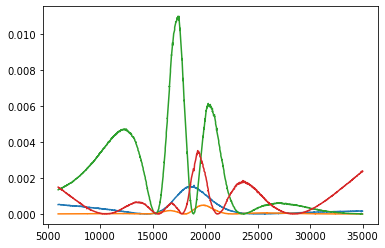

In [150]:
V_gen_model = Gen_amp_model(frequencies, fit_gen[0])
residual_gen = amplitudeGen - V_gen_model
V_R_model = R_amp_model(frequencies, fit_R[0], fit_R[1], fit_R[2], fit_R[3],fit_R[4])
residual_R = amplitudeR - V_R_model
V_L_model = L_amp_model(frequencies, fit_L[0], fit_L[1], fit_L[2], fit_L[3])
residual_L = amplitudeL - V_L_model
V_C_model = C_amp_model(frequencies, fit_C[0], fit_C[1], fit_C[2], fit_C[3])
residual_C = amplitudeC - V_C_model

plt.plot(frequencies,residual_gen**2)
plt.plot(frequencies,residual_R**2)
plt.plot(frequencies,residual_L**2)
plt.plot(frequencies,residual_C**2)


In [151]:
chisq_gen = sum((residual_gen/ ampError)**2)
degrees_of_freedom_gen = len(residual_gen) - len(initial_guess_gen)
reduced_chisq_gen = chisq_gen / degrees_of_freedom_gen
1
chisq_R = sum((residual_R/ ampError)**2)
degrees_of_freedom_R = len(residual_R) - len(initial_guess_R)
reduced_chisq_R = chisq_R / degrees_of_freedom_R

chisq_L = sum((residual_L/ ampError)**2) #typo corrected
degrees_of_freedom_L = len(residual_L) - len(initial_guess_L)
reduced_chisq_L = chisq_L / degrees_of_freedom_L

chisq_C = sum((residual_C/ ampError)**2) #typo corrected
degrees_of_freedom_C = len(residual_C) - len(initial_guess_C)
reduced_chisq_C = chisq_C / degrees_of_freedom_C

print('GEN')
print('chi-square      = ',chisq_gen)
print('degrees of freedom = ',degrees_of_freedom_gen)
print('reduced chi-square = ',reduced_chisq_gen)

print('R')
print('chi-square        = ',chisq_R)
print('degrees of freedom = ',degrees_of_freedom_R)
print('reduced chi-square = ',reduced_chisq_R)

print('L')
print('chi-square         = ',chisq_L)
print('degrees of freedom = ',degrees_of_freedom_L)
print('reduced chi-square = ',reduced_chisq_L)

print('C')
print('chi-square    = ',chisq_C)
print('degrees of freedom = ',degrees_of_freedom_C)
print('reduced chi-square = ',reduced_chisq_C)


GEN
chi-square      =  191.6331703642125
degrees of freedom =  953
reduced chi-square =  0.20108412420169203
R
chi-square        =  34.775172563284336
degrees of freedom =  949
reduced chi-square =  0.03664401745340815
L
chi-square         =  1283.76610277681
degrees of freedom =  950
reduced chi-square =  1.3513327397650632
C
chi-square    =  475.656619273468
degrees of freedom =  950
reduced chi-square =  0.5006911781825979


## Plotting data
Now that we're done with fitting let's plot our data using [matplotlib](https://matplotlib.org).

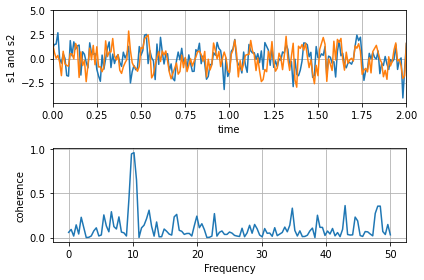

In [152]:
# #Plot preparation through global runtime parameters change
# mpl.rcParams['lines.marker']  #None
# mpl.rcParams['lines.markersize']  #6.0
# mpl.rcParams['lines.linewidth']   # 1.5
# mpl.rcParams['axes.prop_cycle']
#
# fig = plt.figure()
# mpl.rcParams['figure.figsize']   # [6.4,4.8] 6.4 is the width, 4.8 is the height
# fig = plt.figure(figsize=(10,6))
# ax = plt.axes((0.1,0.1,0.5,0.8))
# # ax.spines['right'].set_visible(True)
# # ax.spines['left'].set_visible(True)
# # ax.spines['bottom'].set_visible(False)
# # ax.spines['top'].set_visible(False)
# ax.tick_params(axis='x',which='major',direction='out',length=10,width=5,color='red',pad=15,labelsize=15,labelcolor='green',
#                labelrotation=15)
# ax.set_xticks([0.2,1])
# ax.set_xticklabels(['pos1','pos2'])

# Fixing random state for reproducibility
np.random.seed(19680801)

dt = 0.01
t = np.arange(0, 30, dt)
nse1 = np.random.randn(len(t))                 # white noise 1
nse2 = np.random.randn(len(t))                 # white noise 2

# Two signals with a coherent part at 10Hz and a random part
s1 = np.sin(2 * np.pi * 10 * t) + nse1
s2 = np.sin(2 * np.pi * 10 * t) + nse2

fig, axs = plt.subplots(2, 1)
axs[0].plot(t, s1, t, s2)
axs[0].set_xlim(0, 2)
axs[0].set_xlabel('time')
axs[0].set_ylabel('s1 and s2')
axs[0].grid(True)
axs[1].grid(True)

cxy, f = axs[1].cohere(s1, s2, 256, 1. / dt)
axs[1].set_ylabel('coherence')
axs[1].grid(True)

fig.tight_layout()
plt.show()

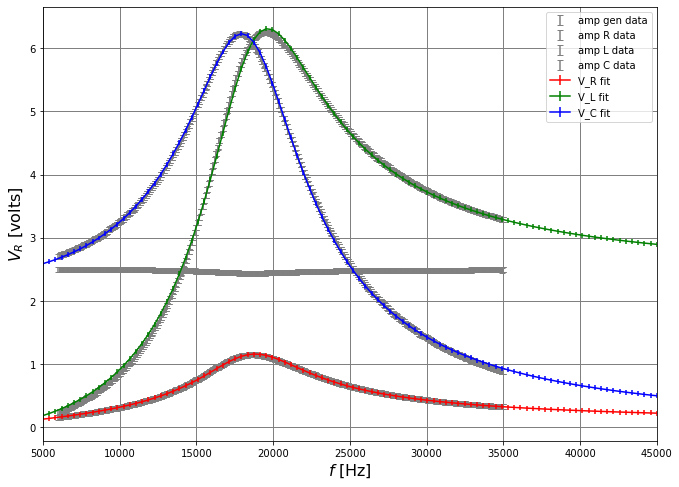

In [153]:
plt.figure(figsize = (11,8))                  #specify figure size (inches)
#for default size, type plt.figure()

plt.xlabel(r"$f$ [Hz]", fontsize = 16) #label axis (using LaTeX commands)
plt.ylabel(r"$V_R$ [volts]", fontsize = 16)   #use 18 point font for label text

# Plotting the actual experimental data
plt.errorbar(frequencies, amplitudeGen,
             xerr=None, yerr=ampError,
             linestyle = 'none',
             color = 'gray',
             capsize = 3, capthick = 1, label = "amp gen data")
plt.errorbar(frequencies, amplitudeR,
             xerr=None, yerr=ampError,
             linestyle = 'none',
             color = 'gray',
             capsize = 3, capthick = 1, label = "amp R data")
plt.errorbar(frequencies, amplitudeL,
             xerr=None, yerr=ampError,
             linestyle = 'none',
             color = 'gray',
             capsize = 3, capthick = 1, label = "amp L data")
plt.errorbar(frequencies, amplitudeC,
             xerr=None, yerr=ampError,
             linestyle = 'none',
             color = 'gray',
             capsize = 3, capthick = 1, label = "amp C data")

#create curve showing fit to data
freq_fit = np.linspace(5000, 45000, 100)
Vgen_fit = Gen_amp_model(freq_fit,fit_gen[0])
VR_fit = R_amp_model(freq_fit, fit_R[0], fit_R[1], fit_R[2],fit_R[3],fit_R[4])
VL_fit = L_amp_model(freq_fit, fit_L[0], fit_L[1], fit_L[2],fit_L[3])
VC_fit = C_amp_model(freq_fit, fit_C[0], fit_C[1], fit_C[2],fit_C[3])

#plotting the fitting curves
# plt.errorbar(freq_fit, Vgen_fit, xerr = None, yerr = sigma, color = 'yellow', label = 'V_gen fit' )
plt.errorbar(freq_fit, VR_fit, xerr = None, yerr = sigma_y, color = 'red', label = 'V_R fit' )
plt.errorbar(freq_fit, VL_fit, xerr = None, yerr = sigma_y, color = 'green', label = 'V_L fit' )
plt.errorbar(freq_fit, VC_fit, xerr = None, yerr = sigma_y, color = 'blue', label = 'V_C fit' )
plt.grid(color='gray',which='major', linestyle='-', linewidth=1)
plt.grid(color='gray',which='minor', linestyle='-')
plt.xlim(5000 , 45000)
# plt.ylim(0.0,7.0)
# plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360],
#            ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.legend(loc = 'best')

plt.savefig('../figs/Amplitudes.pdf')

Let's now compare with expected values

NameError: name 'sigma' is not defined

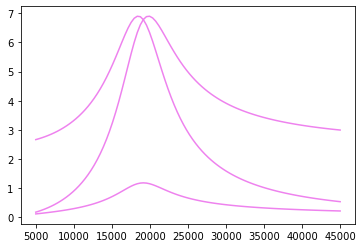

In [154]:
VF_exp = Gen_amp_model(freq_fit,2.5)
VR_exp = R_amp_model(freq_fit, 996.7,2100,0.047413,1.46E-09,2.5)
VL_exp = L_amp_model(freq_fit, 2100,0.047413,1.46E-09,2.5)
VC_exp = C_amp_model(freq_fit,2100,0.047413,1.46E-09,2.5 )

# plt.plot(freq_fit,VF_exp)
plt.errorbar(freq_fit, VR_exp, xerr = None, yerr = None, color = 'violet', label = 'V_R fit' )
plt.errorbar(freq_fit, VL_exp, xerr = None, yerr = None, color = 'violet', label = 'V_L fit' )
plt.errorbar(freq_fit, VC_exp, xerr = None, yerr = None, color = 'violet', label = 'V_C fit' )
# plt.errorbar(freq_fit, Vgen_fit, xerr = None, yerr = sigma, color = 'red', label = 'V_gen fit' )
plt.errorbar(freq_fit, VR_fit, xerr = None, yerr = sigma, color = 'red', label = 'V_R fit' )
plt.errorbar(freq_fit, VL_fit, xerr = None, yerr = sigma, color = 'red', label = 'V_L fit' )
plt.errorbar(freq_fit, VC_fit, xerr = None, yerr = sigma, color = 'red', label = 'V_C fit' )
